In [94]:
import cv2
import numpy as np

np.set_printoptions(precision=2, suppress=True)

# input: 사용된 calibration pattern 정보, 촬영된 calibration pattern 사진
wp = 9  # calibration pattern 가로점 수
hp = 5  # calibration pattern 세로점 수
length = 25  # calibration pattern 한 변 길이
directory = 'chess/'
imageExtension = '.jpg'  # 파일 확장자
startImageNum = 1  # 읽기 시작하는 사진 번호
endImageNum = 16  # 읽기를 끝내는 사진 번호 + 1

# Calibration patter 상의 특징점 좌표 (추후 2차원 사진 좌표와 매칭)
objp = np.zeros((wp*hp, 3), np.float32)  # 대입 (0, 0, 0) (1, 0, 0) ... (6, 7, 0)
objp[:, :2] = np.mgrid[0:wp, 0:hp].T.reshape(-1, 2)
objp[:, :2] *= length  # 실제 크기 대입을 위해 length 곱함
objpoints = []  # 실제 세계에서의 3d 특징점 집합
imgpoints = []  # 촬영된 사진에서 2d 특징점 집합
findImages = []  # calibration pattern이 성공적으로 인식된 사진 번호 집합

for i in range(startImageNum, endImageNum):
    img = cv2.imread(directory + str(i) + imageExtension)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)  # 사진에서 특징점 찾음
    img_shape = gray.shape[::-1]  # 사진의 가로 및 세로 크기
    
    # 특징점이 사진에서 찾아진 경우
    if ret == True:
        print(f'{i}번째 이미지에서 calibration pattern 특징점 인식 성공')
        objpoints.append(objp)  # 집합에 3d정보 추가
        imgpoints.append(corners)  # 집합에 2d정보 추가
        findImages.append(i)  # 집합에 특징점 찾아진 사진 번호 추가
      # 특징점을 사진에서 찾지 못한 경우
    else:
        print(f'{i}번째 이미지에서 calibration pattern 특징점 인식 실패')
        
# M: intrinsic parameter, D: distortion parameter
# rvecs: camera와 calibration pattern의 좌표계 사이 rotation 정보 (axis-angle form)
# tvecs: camera와 calibration pattern의 좌표계 사이 translation 정보
# rt: reprojection error,
rt, M, D, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_shape, None, None)
print(f'Intrinsic matrix M:\n{M}')
np.savetxt(directory + "\Cal_intrinsic.txt", M,
           fmt='%.2f')  # intrinsic matrix 저장

# 외부 파라미터는 패턴 또는 카메라가 움직일 때 마다 변경, 내부 파라미터는 카메라 내부 특성으로 고정
W = np.full((3, 4), 0.0)
R = np.full((3, 3), 0.0)

for i, no in enumerate(findImages):
    rvec = rvecs[i]
    tvec = tvecs[i]
    cv2.Rodrigues(rvec, R)
    W[0:3, 0:3] = R
    W[0:3, 3:4] = tvec  # np.reshape(tvec,(3,1))
    print(f'{no}th Extrinsic matrix W:\n{W}')
    np.savetxt(directory + "\Cal_extrinsic"+str(no) +
              ".txt", W, fmt='%.2f')  # extrinsic matrix 저장
    
print(f'Distorsion coefficient:\n{D}')
print(f"Reprojection error: {rt}")


1번째 이미지에서 calibration pattern 특징점 인식 성공
2번째 이미지에서 calibration pattern 특징점 인식 성공
3번째 이미지에서 calibration pattern 특징점 인식 성공
4번째 이미지에서 calibration pattern 특징점 인식 성공
5번째 이미지에서 calibration pattern 특징점 인식 성공
6번째 이미지에서 calibration pattern 특징점 인식 성공
7번째 이미지에서 calibration pattern 특징점 인식 성공
8번째 이미지에서 calibration pattern 특징점 인식 성공
9번째 이미지에서 calibration pattern 특징점 인식 성공
10번째 이미지에서 calibration pattern 특징점 인식 성공
11번째 이미지에서 calibration pattern 특징점 인식 성공
12번째 이미지에서 calibration pattern 특징점 인식 성공
13번째 이미지에서 calibration pattern 특징점 인식 성공
14번째 이미지에서 calibration pattern 특징점 인식 성공
15번째 이미지에서 calibration pattern 특징점 인식 성공
Intrinsic matrix M:
[[3144.89    0.   1534.82]
 [   0.   3162.3  1582.55]
 [   0.      0.      1.  ]]
1th Extrinsic matrix W:
[[ -1.    -0.02   0.07 118.67]
 [  0.03  -0.99   0.13  20.74]
 [  0.07   0.13   0.99 342.02]]
2th Extrinsic matrix W:
[[  1.    -0.03   0.03 -63.16]
 [  0.04   1.    -0.09 -74.08]
 [ -0.03   0.09   1.   371.02]]
3th Extrinsic matrix W:
[[ -1.    -0.01  -0.03 118.85]
 

In [201]:
import cv2
import numpy as np

np.set_printoptions(precision=3, suppress=True)
wp = 3 # calibration pattern 가로점 수
hp = 3 # calibration pattern 세로점 수
length = 25 # calibration pattern 한 변 길이
directory = 'tracking/'

imageExtension = '.jpg' # 파일 확장자
startImageNum = 1 # 읽기 시작하는 사진 번호
endImageNum = 13 # 읽기를 끝내는 사진 번호 + 1

objp = np.zeros((wp*hp, 3), np.float32)
objp[:, :2] = np.mgrid[0:wp, 0:hp].T.reshape(-1, 2)
objp[:, :2] *= length

# Intrinsic matrix 로드
intrinsic_file = 'chess/Cal_intrinsic.txt'
intrinsic = np.loadtxt(intrinsic_file)

distorsion_file = 'chess/Cal_distorsion.txt'
distorsion = np.loadtxt(distorsion_file)
W = np.full((3, 4), 0.0)
R = np.full((3, 3), 0.0)

tvecs = []
corners_list = []

for i in range(startImageNum, endImageNum):
    img = cv2.imread(directory + str(i) + imageExtension)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)
    print(corners)
    img_shape = gray.shape[::-1]  # 사진의 가로 및 세로 크기
    if ret == True:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 성공')
        ret, rvec, tvec = cv2.solvePnP(objp, corners, intrinsic, distorsion)
        cv2.Rodrigues(rvec, R)
        W[0:3, 0:3] = R
        W[0:3, 3:4] = tvec  # np.reshape(tvec,(3,1))
        print(f'{i}th HTM matrix W:\n{W}')

        # tvec 및 corners의 특정 인덱스 값 저장
        tvecs.append(tvec.flatten())
    else:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 실패')

# numpy 배열로 변환
tvecs = np.array(tvecs)

print('tvec\n', tvecs)

[[[ 996.363 1902.414]]

 [[ 998.147 2053.743]]

 [[1000.129 2197.865]]

 [[ 827.06  1908.135]]

 [[ 831.213 2060.874]]

 [[ 835.739 2209.966]]

 [[ 655.122 1913.155]]

 [[ 661.802 2068.353]]

 [[ 667.923 2221.198]]]
1번째 이미지에서 pattern 특징점 인식 성공
1th HTM matrix W:
[[ -0.022  -0.995  -0.095 -82.917]
 [  0.948   0.01   -0.318  48.245]
 [  0.317  -0.097   0.943 492.63 ]]
[[[2239.385 1474.684]]

 [[2223.688 1630.325]]

 [[2206.382 1777.656]]

 [[2074.001 1484.239]]

 [[2061.478 1640.726]]

 [[2050.377 1792.349]]

 [[1905.615 1493.174]]

 [[1896.799 1650.742]]

 [[1891.033 1805.324]]]
2번째 이미지에서 pattern 특징점 인식 성공
2th HTM matrix W:
[[ -0.012  -0.979  -0.202 102.63 ]
 [  0.911   0.073  -0.407 -16.478]
 [  0.413  -0.189   0.891 464.34 ]]
[[[1327.103 1863.744]]

 [[1344.073 2086.846]]

 [[1358.833 2309.06 ]]

 [[1105.333 1892.587]]

 [[1122.838 2121.11 ]]

 [[1139.914 2350.813]]

 [[ 870.699 1925.121]]

 [[ 890.3   2160.35 ]]

 [[ 909.188 2394.737]]]
3번째 이미지에서 pattern 특징점 인식 성공
3th HTM matrix W:
[[

Accuracy of width: 90.64%
Accuracy of height: 98.95%
Mean width: 181.27
Mean height: 101.05
Variance of width: 403.85
Variance of height: 465.67


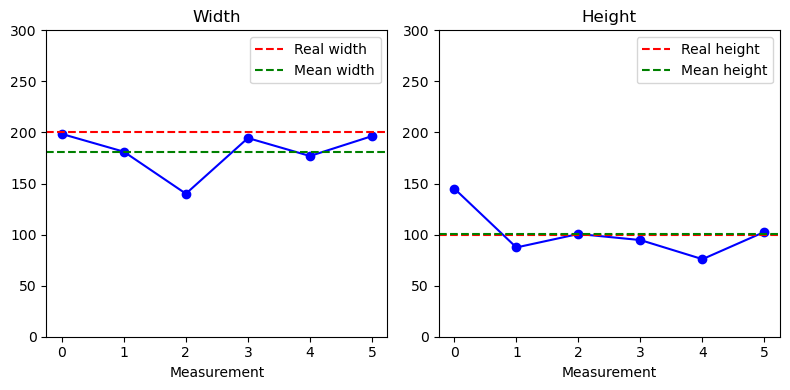

In [213]:
import numpy as np
import matplotlib.pyplot as plt

widths = []
heights = []

for i in range(3):
    width1 = tvecs[4*i] - tvecs[1+4*i]
    width1 = np.linalg.norm(width1)
    width2 = tvecs[2+4*i] - tvecs[3+4*i]
    width2 = np.linalg.norm(width2)
    height1 = tvecs[2+4*i] - tvecs[4*i]
    height1 = np.linalg.norm(height1)
    height2 = tvecs[3+4*i] - tvecs[1+4*i]
    height2 = np.linalg.norm(height2)
    
    widths.extend([width1, width2])
    heights.extend([height1, height2])

# 평균 계산
mean_width = np.mean(widths)
mean_height = np.mean(heights)

# 분산 계산
var_width = np.var(widths)
var_height = np.var(heights)

# 정확도 계산
real_width = 200
real_height = 100

accuracy_width = 1 - abs(mean_width - real_width) / real_width
accuracy_height = 1 - abs(mean_height - real_height) / real_height

# ANSI 이스케이프 시퀀스를 사용하여 bold 처리
print(f"\033[1mAccuracy of width: {accuracy_width:.2%}\033[0m")
print(f"\033[1mAccuracy of height: {accuracy_height:.2%}\033[0m")
print(f"\033[1mMean width: {mean_width:.2f}\033[0m")
print(f"\033[1mMean height: {mean_height:.2f}\033[0m")
print(f"\033[1mVariance of width: {var_width:.2f}\033[0m")
print(f"\033[1mVariance of height: {var_height:.2f}\033[0m")

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # plot 크기 조정

axs[0].plot(widths, 'bo-')
axs[0].set_ylim(0, 300) 
axs[0].axhline(real_width, color='r', linestyle='--', label='Real width')
axs[0].axhline(mean_width, color='g', linestyle='--', label='Mean width')
axs[0].set_title("Width")
axs[0].set_xlabel("Measurement")
axs[0].legend()

axs[1].plot(heights, 'bo-')
axs[1].set_ylim(0, 300)
axs[1].axhline(real_height, color='r', linestyle='--', label='Real height')
axs[1].axhline(mean_height, color='g', linestyle='--', label='Mean height')
axs[1].set_title("Height")
axs[1].set_xlabel("Measurement")
axs[1].legend()

plt.tight_layout()
plt.show()